In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

dataport not available, will only be able to load data locally


In [2]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa, flowfa_ident
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

In [3]:
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static_edited_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [4]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 295178.62it/s]


In [5]:
grid_mean_pred_config = {
    "type": "cortex",
    "input_dimensions": 2,
    "hidden_layers": 4,
    "hidden_features": 20,
    "nonlinearity": "ReLU",
    "final_tanh": True,
}

image_model_config = {
    "pad_input": False,
    "stack": -1,
    "layers": 4,
    "input_kern": 15,
    "gamma_input": 1,
    "gamma_readout": 2.439,
    "hidden_dilation": 1,
    "hidden_kern": 13,
    "hidden_channels": 64,
    "n_se_blocks": 0,
    "depth_separable": True,
    "share_features": False,
    "share_grid": False,
    "init_sigma": 0.4,
    "init_mu_range": 0.55,
    "gauss_type": "full",
    "grid_mean_predictor": grid_mean_pred_config,
}

In [6]:
model_name = "flowfa_ident"
d_latent = 3
sample_transform = "learned-leaky"
mean_transform = "learned"
per_neuron_transform = True
unit_variance_constraint = False

model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "mean_transform": mean_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}
model = flowfa_ident(dataloaders, random_seed, **model_config)

In [7]:
index_name_of_dataloader = next(iter(dataloaders["train"]))
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))
img_indexes = indexes[inv == inv[0]]
print(img_indexes)

[0 1 2 3 4 5 6 7 8 9]


In [8]:
print(model.sample_transform)

Flow(
  (layers): ModuleList(
    (0): Affine(
      init_t=Parameter containing:
      tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0.,

102
435
860
270
106
71
700
20
614


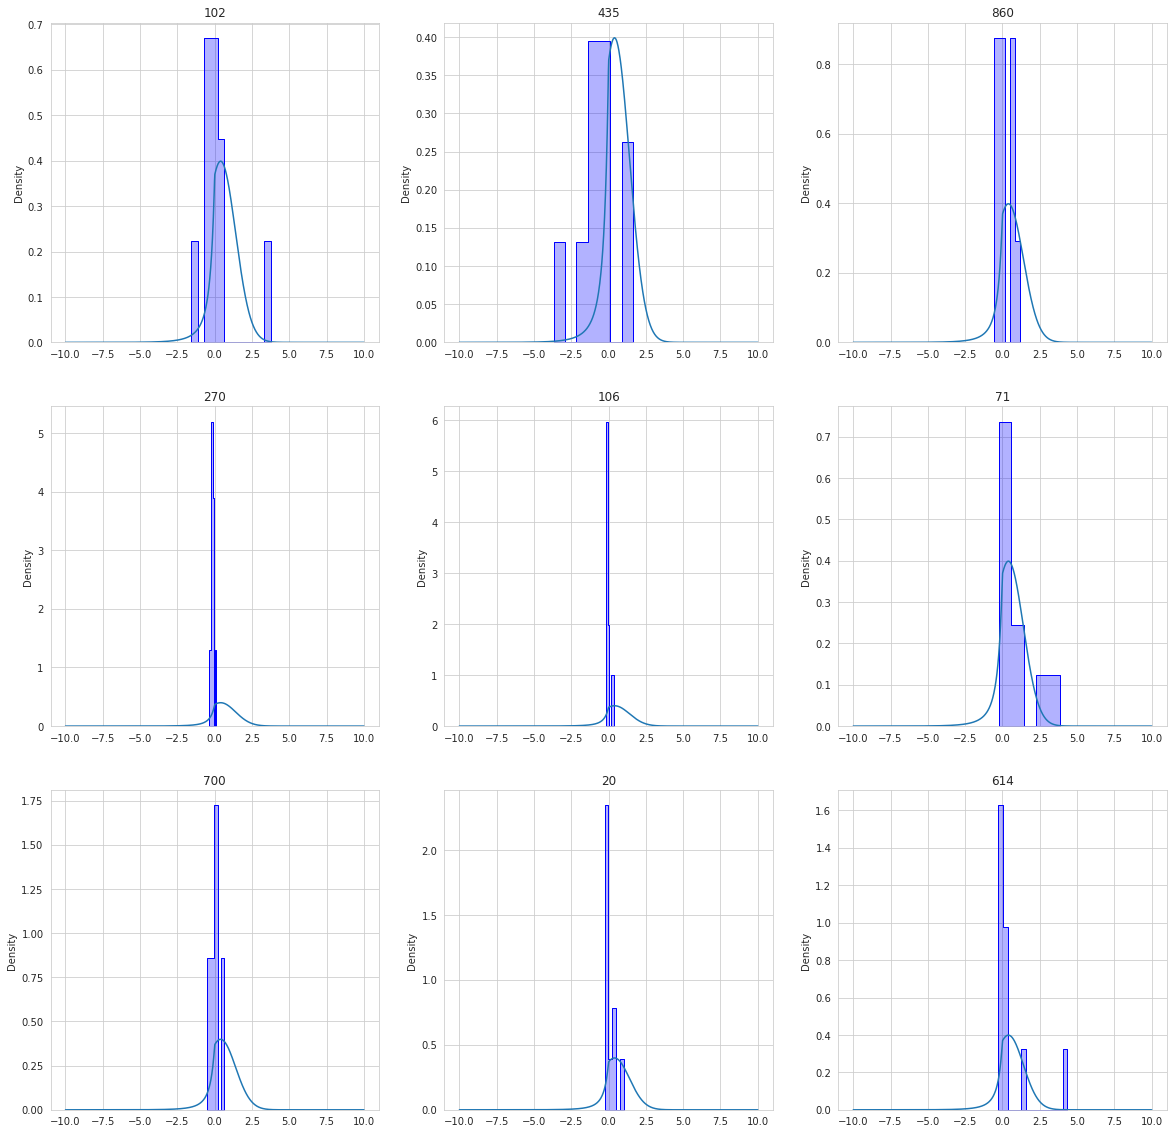

In [9]:
#print distributions before training
batch = (next(iter(dataloaders["test"][index_name_of_dataloader])))
inputs, targets = batch[:2]
mu = model.forward(*batch, data_key=None).to("cpu")
points = torch.linspace(-10,10, 1000).to(device)
test = torch.ones(1000, 1000)
for i in range(1000):
    test[: ,i] = points
transformed_targets, logdet = model.sample_transform(test.to(device))
from matplotlib.pyplot import figure

random_neurons = np.random.choice(1000,9)
normal = torch.distributions.normal.Normal(mu[0][img_indexes[0]], torch.tensor([1.0]))
fig, ax = plt.subplots(3,3, figsize=(20,20))
values_before = normal.log_prob(transformed_targets.detach().to("cpu"))
for i, neuron in enumerate(random_neurons):
    print(neuron)
    ax[i//3][i%3].plot(points.detach().cpu(), torch.exp(values_before.detach()[:,neuron] + logdet.detach().to("cpu")[:,neuron]))
    ax[i//3][i%3].set_title(str(neuron))
    sns.histplot(targets[img_indexes][:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.3)
    #ax[i//3][i%3].hist(targets[img_indexes][:,neuron].detach().cpu().numpy(), color="blue", density=True)
plt.show()

In [10]:
trainer_config = {
    "epochs": 500,
    "device": "cuda",
    "lr": 0.005,
    "use_avg_loss": True
}
out = None
## The following line would train the model (upon availability of the dataset)
out = base_trainer(model, dataloaders, random_seed, **trainer_config)

Score improved (nan --> 1861.736450).


100%|██████████| 70/70 [00:03<00:00, 20.08it/s]


Epoch 1/500 | train loss: 1861.496338 | val loss: 1557.371948
Score improved (1861.736450 --> 1557.371948).


100%|██████████| 70/70 [00:03<00:00, 20.15it/s]


Epoch 2/500 | train loss: 1581.085327 | val loss: 1534.626953
Score improved (1557.371948 --> 1534.626953).


100%|██████████| 70/70 [00:03<00:00, 20.14it/s]


Epoch 3/500 | train loss: 1481.138306 | val loss: 1527.303589
Score improved (1534.626953 --> 1527.303589).


100%|██████████| 70/70 [00:03<00:00, 20.17it/s]


Epoch 4/500 | train loss: 1616.218384 | val loss: 1521.090210
Score improved (1527.303589 --> 1521.090210).


100%|██████████| 70/70 [00:03<00:00, 20.17it/s]


Epoch 5/500 | train loss: 1577.455688 | val loss: 1525.755981
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.12it/s]


Epoch 6/500 | train loss: 1468.153687 | val loss: 1521.131592
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.11it/s]


Epoch 7/500 | train loss: 1538.149780 | val loss: 1520.445190
Score improved (1521.090210 --> 1520.445190).


100%|██████████| 70/70 [00:03<00:00, 20.19it/s]


Epoch 8/500 | train loss: 1488.376587 | val loss: 1520.928589
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.18it/s]


Epoch 9/500 | train loss: 1505.074707 | val loss: 1520.227051
Score improved (1520.445190 --> 1520.227051).


100%|██████████| 70/70 [00:03<00:00, 20.17it/s]


Epoch 10/500 | train loss: 1555.056641 | val loss: 1520.951660
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.13it/s]


Epoch 11/500 | train loss: 1589.606323 | val loss: 1518.060547
Score improved (1520.227051 --> 1518.060547).


100%|██████████| 70/70 [00:03<00:00, 20.09it/s]


Epoch 12/500 | train loss: 1478.265137 | val loss: 1518.677246
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.10it/s]


Epoch 13/500 | train loss: 1540.343384 | val loss: 1519.269653
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.12it/s]


Epoch 14/500 | train loss: 1528.677124 | val loss: 1522.552246
EarlyStopping counter: 3 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.13it/s]


Epoch 15/500 | train loss: 1612.836670 | val loss: 1519.321777
EarlyStopping counter: 4 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.14it/s]


Epoch 16/500 | train loss: 1473.512085 | val loss: 1518.020874
Score improved (1518.060547 --> 1518.020874).


100%|██████████| 70/70 [00:03<00:00, 20.15it/s]


Epoch 17/500 | train loss: 1631.121704 | val loss: 1515.235596
Score improved (1518.020874 --> 1515.235596).


100%|██████████| 70/70 [00:03<00:00, 20.16it/s]


Epoch 18/500 | train loss: 1515.411255 | val loss: 1516.803467
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.19it/s]


Epoch 19/500 | train loss: 1529.851440 | val loss: 1516.577026
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.20it/s]


Epoch 20/500 | train loss: 1507.370850 | val loss: 1513.046997
Score improved (1515.235596 --> 1513.046997).


100%|██████████| 70/70 [00:03<00:00, 20.19it/s]


Epoch 21/500 | train loss: 1455.575317 | val loss: 1515.639160
EarlyStopping counter: 1 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.17it/s]


Epoch 22/500 | train loss: 1530.753662 | val loss: 1521.129150
EarlyStopping counter: 2 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.17it/s]


Epoch 23/500 | train loss: 1483.390991 | val loss: 1516.139893
EarlyStopping counter: 3 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.21it/s]


Epoch 24/500 | train loss: 1522.578613 | val loss: 1521.126099
EarlyStopping counter: 4 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.13it/s]


Epoch 25/500 | train loss: 1459.815796 | val loss: 1522.636841
EarlyStopping counter: 5 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.21it/s]


Epoch 26/500 | train loss: 1486.002930 | val loss: 1518.516235
EarlyStopping counter: 6 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.22it/s]


Epoch 27/500 | train loss: 1457.339111 | val loss: 1517.497559
EarlyStopping counter: 7 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.21it/s]


Epoch 28/500 | train loss: 1462.572998 | val loss: 1522.508911
EarlyStopping counter: 8 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.22it/s]


Epoch 29/500 | train loss: 1598.528687 | val loss: 1516.145020
EarlyStopping counter: 9 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.22it/s]


Epoch 30/500 | train loss: 1494.858765 | val loss: 1516.172119
EarlyStopping counter: 10 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.21it/s]


Epoch 31/500 | train loss: 1498.567139 | val loss: 1515.609375
EarlyStopping counter: 11 out of 20
Epoch    31: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..
Applying changes..


100%|██████████| 70/70 [00:03<00:00, 20.19it/s]


Epoch 32/500 | train loss: 1484.612183 | val loss: 1518.466309
EarlyStopping counter: 12 out of 20
Retrieve best model..


100%|██████████| 70/70 [00:03<00:00, 20.18it/s]


Epoch 33/500 | train loss: 1439.230591 | val loss: 1517.438477
EarlyStopping counter: 13 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.17it/s]


Epoch 34/500 | train loss: 1436.363281 | val loss: 1519.197754
EarlyStopping counter: 14 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.16it/s]


Epoch 35/500 | train loss: 1548.801514 | val loss: 1521.056641
EarlyStopping counter: 15 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.15it/s]


Epoch 36/500 | train loss: 1478.169922 | val loss: 1517.152588
EarlyStopping counter: 16 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.15it/s]


Epoch 37/500 | train loss: 1510.212158 | val loss: 1515.877075
EarlyStopping counter: 17 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.15it/s]


Epoch 38/500 | train loss: 1607.674072 | val loss: 1515.792480
EarlyStopping counter: 18 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.19it/s]


Epoch 39/500 | train loss: 1503.029785 | val loss: 1516.574219
EarlyStopping counter: 19 out of 20


100%|██████████| 70/70 [00:03<00:00, 20.23it/s]


Epoch 40/500 | train loss: 1554.921021 | val loss: 1519.623291
EarlyStopping counter: 20 out of 20
Early stopping at epoch 39. Best val loss: 1513.047
Retrieve best model..


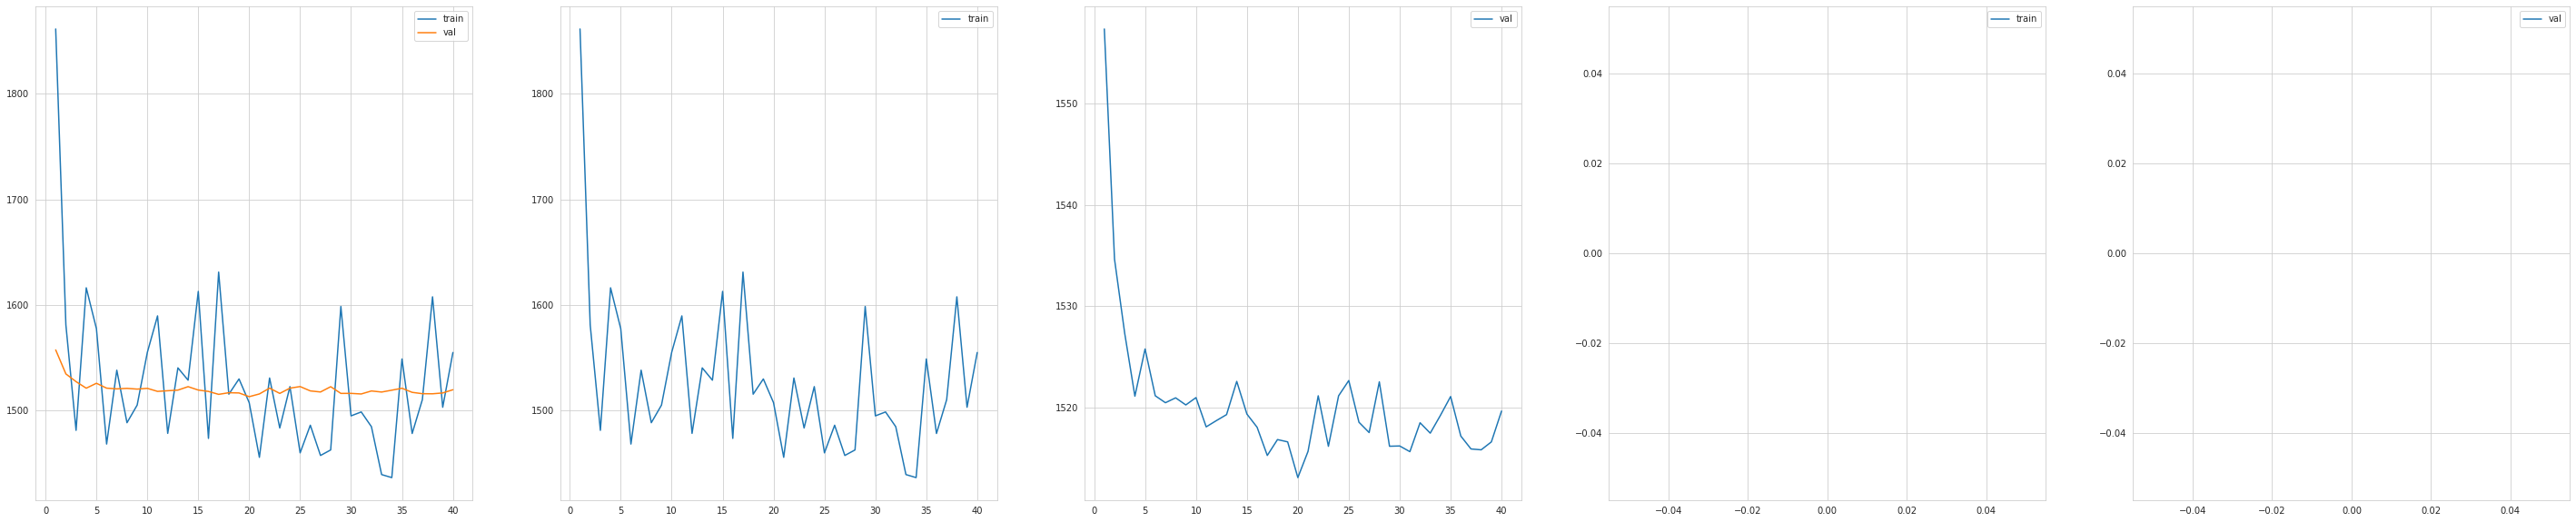

In [11]:
if out is not None:
    fig, ax = plt.subplots(1,5,figsize=(50,10))
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[1].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[2].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[3].plot((np.arange(len(out[1][0]))+1)[40:], out[1][0][40:], label="train")
    ax[4].plot((np.arange(len(out[1][0]))+1)[40:], out[1][1][40:], label="val")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    ax[4].legend()
    plt.show()

In [12]:
#model.load_state_dict(torch.load("edited_data_only_ident"))
#model.eval()

In [13]:
#torch.save(model.state_dict(), "edited_data_only_ident")

In [14]:
print(model)

FlowFA_Ident(
  (encoding_model): Encoder(
    (core): SE2dCore(
      (_input_weights_regularizer): LaplaceL2norm(
        (laplace): Laplace()
      )
      (features): Sequential(
        (layer0): Sequential(
          (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (layer1): Sequential(
          (ds_conv): DepthSeparableConv2d(
            (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
            (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
     

102
435
860
270
106
71
700
20
614


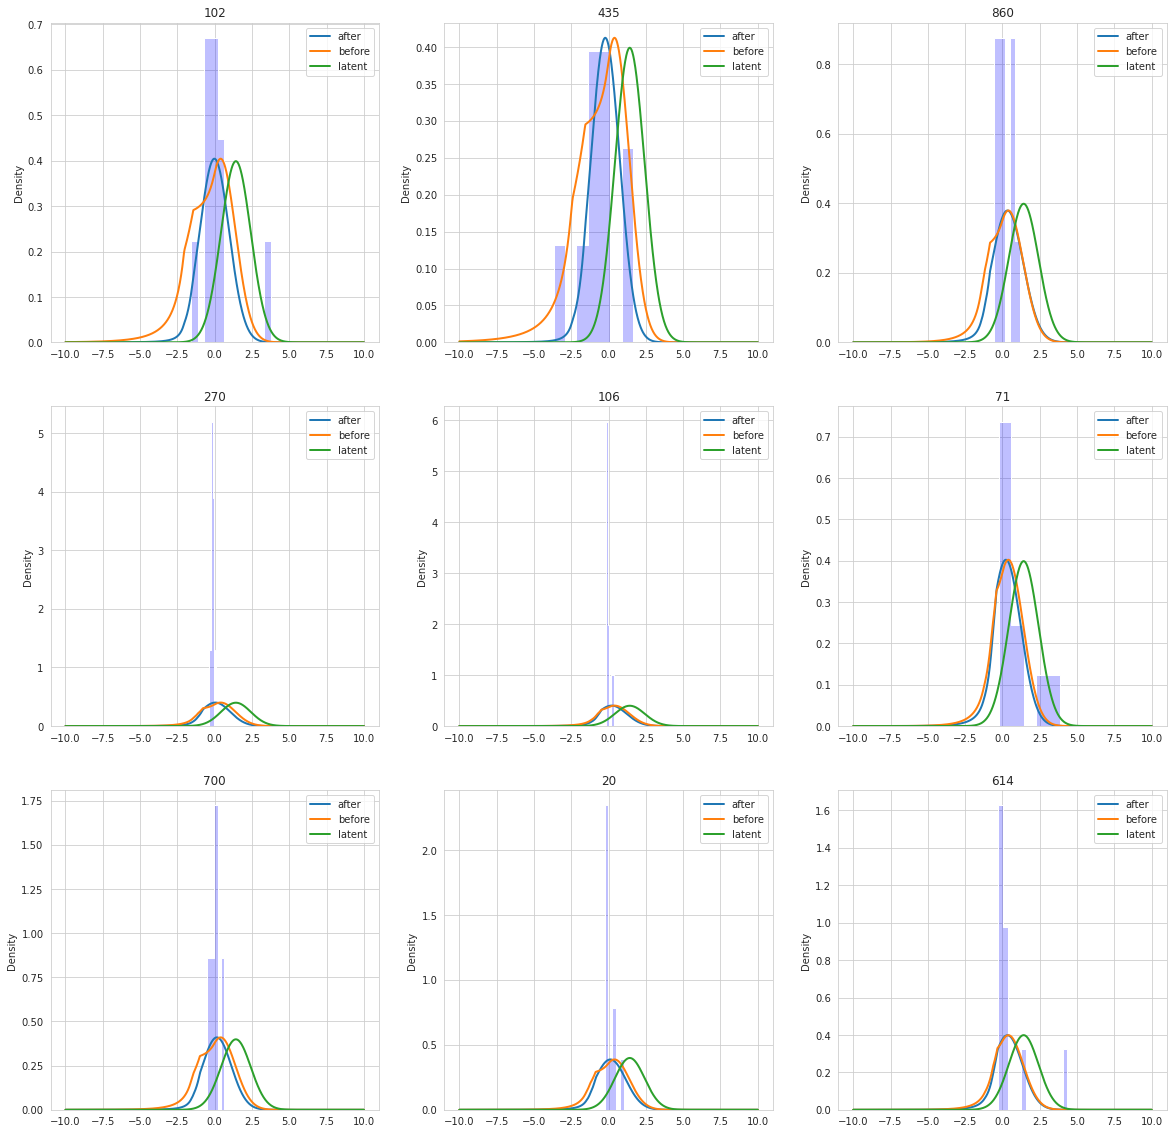

In [15]:
#print distributions after training
mu = model.forward(*batch, data_key=None).to("cpu")
transformed_targets, logdet = model.sample_transform(test.to(device))
from matplotlib.pyplot import figure
normal = torch.distributions.normal.Normal(mu[0][img_indexes[0]], torch.tensor([1.0]))
fig, ax = plt.subplots(3,3, figsize=(20,20))
for i, neuron in enumerate(random_neurons):
    print(neuron)
    values = normal.log_prob(transformed_targets.detach().to("cpu"))
    ax[i//3][i%3].plot(points.detach().cpu(), torch.exp(values.detach()[:,neuron] + logdet.detach().to("cpu")[:,neuron]), label="after", linewidth=2)
    ax[i//3][i%3].plot(points.detach().cpu(), torch.exp(values_before.detach()[:,neuron] + logdet.detach().to("cpu")[:,neuron]), label="before", linewidth=2)
    ax[i//3][i%3].plot(points.detach().cpu(), torch.exp(normal.log_prob(points.detach().cpu()).detach()), label="latent", linewidth=2)
    ax[i//3][i%3].set_title(str(neuron))
    ax[i//3][i%3].legend()
    sns.histplot(targets[img_indexes][:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.25, edgecolor=None)
    #ax[i//3][i%3].hist(targets[img_indexes][:,neuron].detach().cpu().numpy(), color="blue", density=True)

plt.show()